In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

from sklearn.linear_model import LinearRegression
import yfinance as yf

[*********************100%***********************]  1 of 1 completed


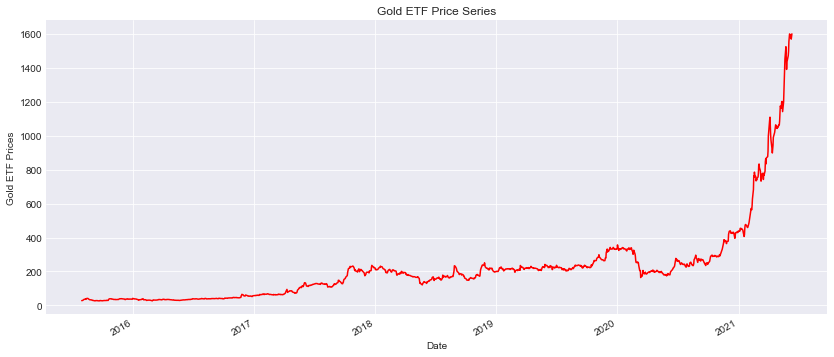

In [239]:
data = yf.download('ADANITRANS.NS', '2008-01-01', '2021-06-14', auto_adjust=True)
data = data[['Close']]
data = data.dropna()
data.Close.plot(figsize=(14,6), color='r')
plt.ylabel('Gold ETF Prices')
plt.title('Gold ETF Price Series')
plt.show()

In [240]:
data['s3m'] = data['Close'].rolling(window=8).mean()
data['s9m'] = data['Close'].rolling(window=21).mean()
data['next_day_price'] = data['Close'].shift(-1)

data = data.dropna()
X = data[['s3m', 's9m']]

y = data['next_day_price']

In [241]:
t=0.8
t = int(t*len(data))

X_train = X[:t]
y_train = y[:t]

X_test = X[t:]
y_test = y[t:]

In [242]:
# Y = m1*X1 + m2*X2 + c

linear = LinearRegression().fit(X_train, y_train)
print('Linear Regression Model')
print('Gold ETF Price= %.2f* 3 days moving average(x1) \
+ %.2f* 9 moving average(x2) + %.2f(constant)' % (linear.coef_[0], linear.coef_[1], linear.intercept_))


Linear Regression Model
Gold ETF Price= 1.31* 3 days moving average(x1) + -0.32* 9 moving average(x2) + 1.75(constant)


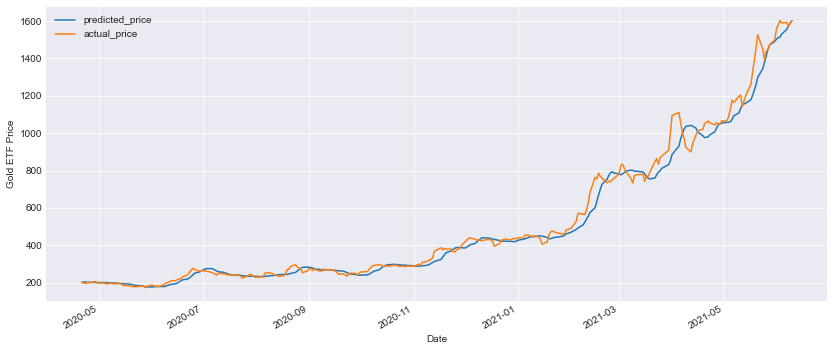

In [243]:
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index = y_test.index, columns=['price'])
predicted_price.plot(figsize=(14,6))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel('Gold ETF Price')
plt.show()

In [244]:
r2_score = linear.score(X[t:], y[t:])*100
float('{0:.2f}'.format(r2_score))

98.57

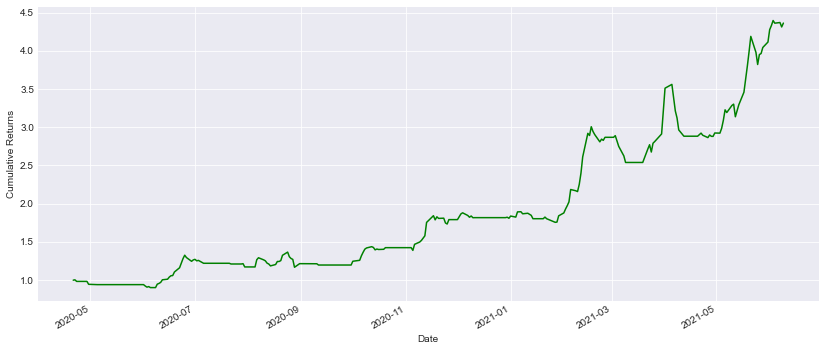

In [245]:
gold = pd.DataFrame()

gold['price'] = data[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)

gold['signal'] = np.where(gold.predicted_price_next_day.shift(1) < gold.predicted_price_next_day,1,0)

gold['strategy_returns'] = gold.signal * gold['gold_returns']
((gold['strategy_returns']+1).cumprod()).plot(figsize=(14,6), color='g')
plt.ylabel('Cumulative Returns')
plt.show()

In [246]:
sharpe = gold['strategy_returns'].mean()/gold['strategy_returns'].std()*(252**0.5)
'Sharpe Ratio %.2f' %(sharpe)

'Sharpe Ratio 3.38'

In [247]:
import datetime as dt
current_date = dt.datetime.now()

# data = yf.download('SBIN.NS', '2008-06-01', current_date, auto_adjust = True)
data['s3'] = data['Close'].rolling(window=3).mean()
data['s9'] = data['Close'].rolling(window=9).mean()

data = data.dropna()

data['predicted_gold_price'] = linear.predict(data[['s3', 's9']])
data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price, 'Buy', 'No Position')

data.tail(1)[['signal', 'predicted_gold_price']].T


Date,2021-06-10
signal,No Position
predicted_gold_price,1578.660584
